<a href="https://colab.research.google.com/github/amelliaaas/PraktikumML_282-305/blob/main/TugasPraktikum4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load Data#

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/My Drive/TugasPraktikum/Covid19-dataset

/content/drive/My Drive/TugasPraktikum/Covid19-dataset


In [4]:
!ls

datasets  test	train


In [5]:
import os
base_dir = 'datasets'

train_dir = os.path.join(base_dir, 'test')
test_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

train_covid_dir = os.path.join(train_dir, 'Covid')
train_normal_dir = os.path.join(train_dir, 'Normal')
train_pneumonia_dir = os.path.join(train_dir, 'Viral Pneumonia')

test_covid_dir = os.path.join(test_dir, 'Covid')
test_normal_dir = os.path.join(test_dir, 'Normal')
test_pneumonia_dir = os.path.join(test_dir, 'Viral Pneumonia')

val_covid_dir = os.path.join(val_dir, 'Covid')
val_normal_dir = os.path.join(val_dir, 'Normal')
val_pneumonia_dir = os.path.join(val_dir, 'Viral Pneumonia')

In [6]:
!ls

datasets  test	train


In [7]:
test_covid_dir

'datasets/train/Covid'

#Splitting Data#

In [8]:
pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio(train_dir, output="Covid19-dataset/datasets", seed=1337, ratio=(.7, .15, .15))

#Preprocessing#

In [8]:
base_dir = "/content/drive/MyDrive/TugasPraktikum/Covid19-dataset/datasets"


In [9]:
# Definisikan path untuk data train test dan validation
# sesuaikan dengan path anda
import os

train_path = os.path.join(base_dir, 'train')
test_path  = os.path.join(base_dir, 'test')
val_path   = os.path.join(base_dir, 'val')

In [10]:
# TULIS KODE ANDA DISINI

from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

batch_size = 32
augmen_gen = ImageDataGenerator(rescale=1. / 255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')

train_gen = augmen_gen.flow_from_directory(
    train_path,
    class_mode = 'categorical',
    shuffle=True,
    target_size = (224,224),
    batch_size=batch_size,
    color_mode ='rgb'
)

val_gen = augmen_gen.flow_from_directory(
    val_path,
    class_mode = 'categorical',
    shuffle=True,
    target_size = (224,224),
    batch_size= batch_size,
    color_mode ='rgb'
)

test_gen = augmen_gen.flow_from_directory(
    test_path,
    class_mode = 'categorical',
    shuffle=False,
    target_size = (224,224),
    batch_size=batch_size,
    color_mode ='rgb',
)

Found 249 images belonging to 3 classes.
Found 59 images belonging to 3 classes.
Found 5 images belonging to 3 classes.


#Modelling#

In [11]:
# IMPORT SEMUA PAKET YANG ANDA PERLUKAN UNTUK MENDEFINISIKAN MODEL DISINI

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
import time

In [12]:
# DEFINISIKAN MODEL ANDA DISINI

#Feature Selection
model = Sequential()

model.add(InputLayer(input_shape=[224,224,3]))
model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Flatten())

#Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.75))
model.add(Dense(3, activation='softmax'))


In [13]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 32)     128       
 hNormalization)                                                 
                                                        

In [14]:
# TULIS CODE CALLBACKS ANDA DISINI

best_model_path = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(best_model_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)
reduce_callback = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=0.0005, verbose=1)
callbacks_list = [checkpoint_callback, reduce_callback]

In [17]:
# Compile model
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(lr=0.001, decay=0.001/20), # decay = learning_rate / batch_size ), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [19]:
# TULIS CODE UNTUK MENCETAK LAMA TRAINING TIME DISINI

start = time.time()
H = model.fit_generator(train_gen, epochs=100,validation_data=val_gen, validation_steps = 4, callbacks=[callbacks_list])

End = time.time()
print ("training time: ", End-start,"s")  # the time would be round to 3 decimal in seconds

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 0.8305 - accuracy: 0.6426WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 4 batches). You may need to use the repeat() function when building your dataset.

Epoch 00001: val_accuracy improved from -inf to 0.42373, saving model to best_model.h5
8/8 [==============================] - 34s 4s/step - loss: 0.8305 - accuracy: 0.6426 - val_loss: 0.6193 - val_accuracy: 0.4237 - lr: 0.0010
Epoch 2/100
8/8 [==============================] - 29s 3s/step - loss: 0.6193 - accuracy: 0.6747 - lr: 0.0010
Epoch 3/100
8/8 [==============================] - 28s 3s/step - loss: 0.4992 - accuracy: 0.6747 - lr: 0.0010
Epoch 4/100
8/8 [==============================] - 28s 3s/step - loss: 0.4366 - accuracy: 0.6908 - lr: 0.0010
Epoch 5/100
8/8 [==============================] - 28s 3s/step - loss: 0.4130 - accur

#Evaluasi#

In [20]:
# IMPORT SEMUA PAKET YANG ANDA PERLUKAN UNTUK MENGEVALUASI MODEL DISINI

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import files

In [21]:
# TULIS CODE UNTUK EVALUASI MODEL DISINI

# model.load_weights(best_model_path)

ypred = model.predict(test_gen)
prediction = np.argmax(ypred, axis=1)
print(classification_report(test_gen.classes, prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



Confusion matrix, without normalization
[[2 0 0]
 [0 2 0]
 [0 0 1]]


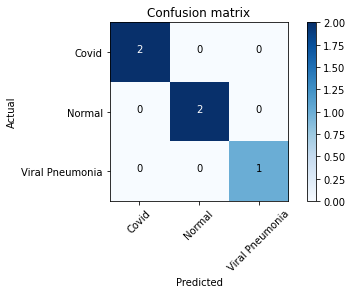

In [22]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

cnf_matrix=confusion_matrix(test_gen.classes,prediction)
plot_confusion_matrix(cnf_matrix, classes=test_gen.class_indices)

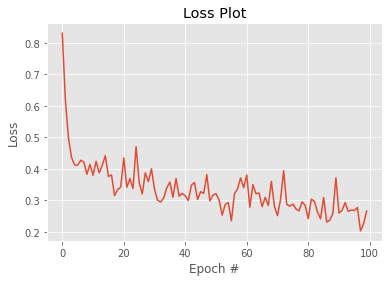

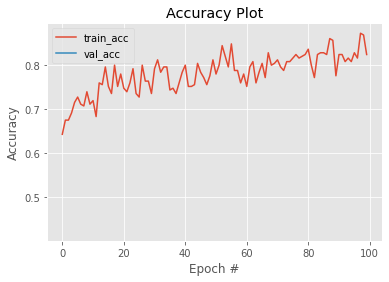

In [24]:
plt.style.use("ggplot")

plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()

plt.plot(H.history["accuracy"], label="train_acc")
plt.plot(H.history["val_accuracy"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()